# Module 13 Lab - Rule Based Machine Learning

## Directions

1. Show all work/steps/calculations. Generate a Markdown/code cells for each answer.
2. You must submit your lab by the deadline to the Lab section of the Course Module where you downloaded this file from.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

We talked about a wide variety of algorithms this module but we're going to concentrate on just two: Decision Trees and Random Forests.

**Problem 1.**

Using the insurance data set, construct a Decision Tree to estimate charges using the Scikit Learn Library [Decision Tree](https://scikit-learn.org/stable/modules/tree.html). You should use validation curves to estimate the best tree depth. With this tree depth, perform 3 rounds of 10 fold cross validation to get a sense of generalization error and learning curves to estimate bias/variance trade-off.

Visualize the tree if possible. 

Compare with your linear regression results. Use Bayesian inference to test the difference of means.

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn
import models
import math
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from numpy.random import rand

sns.set(style="whitegrid")
# load whatever other libraries you need including models.py

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(98526091)

In [4]:
#from the book
def log( x):
    return np.log(float( x))

In [5]:
insurance = pd.read_csv("insurance.csv")

In [6]:
#transformations
region = pd.get_dummies(insurance["region"])
insurance["NE"] = region["northeast"]
insurance["NW"] = region["northwest"]
insurance["SE"] = region["southeast"]
insurance["log_charges"] = insurance["charges"].apply(log)

In [7]:
insurance["sex"] = insurance.sex.apply(lambda x: 1 if x == 'male' else 0)

In [8]:
insurance["smoker"] = insurance.smoker.apply(lambda x: 1 if x == 'yes' else 0)

In [9]:
#taken from a combo in: https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame/48651066
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name == "age" or feature_name == "bmi" or feature_name == "children" or feature_name == "log_charges":
            mean = df[feature_name].mean()
            std = df[feature_name].std()
            result[feature_name]=(df[feature_name]-mean)/std
    return result

In [10]:
#region and charges aren't needed anymore
insurance = insurance.drop(columns="region")
insurance = insurance.drop(columns="charges")

In [11]:
#The data must be normalized to be able to properly compare the values
insuranceNormal = normalize(insurance)

### Decision Tree

In [12]:
dtr = tree.DecisionTreeRegressor()

In [13]:
dtr.fit(insuranceNormal.loc[:, insuranceNormal.columns != 'log_charges'],insuranceNormal['log_charges'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [14]:
dtr.predict(insuranceNormal.loc[:, insuranceNormal.columns != 'log_charges'])

array([ 0.69113536, -1.78935048, -0.75921661, ..., -1.85141424,
       -1.62452158,  1.28463317])

### Validation Curves

In [15]:
def dtr_cross_validation(formula, builder, data, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = {"train": [], "test": []}
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            # y, X for training data
            y = train_data['log_charges']
            X = train_data.loc[:, train_data.columns != 'log_charges']
            model = builder.fit(X, y)
            y_hat = model.predict(X)
            training_r_squared = (stats.pearsonr(y, y_hat)[0])**2
            metrics["train"].append(training_r_squared)
            # y, X for training data
            y = test_data['log_charges']
            X = test_data.loc[:, test_data.columns != 'log_charges']
            y_hat = model.predict(X)
            test_r_squared = (stats.pearsonr(y, y_hat)[0])**2
            metrics["test"].append(test_r_squared)
    return metrics

In [16]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [17]:
formula = "log_charges ~ age + bmi + children + smoker + NE + NW + SE"

In [18]:
test_curve = []
train_curve = []
for k in range(1, 16):
    builder = tree.DecisionTreeRegressor(max_depth=k)
    results = dtr_cross_validation(formula, builder, insuranceNormal)
    test_curve.append(stats.mstats.mquantiles(results['test'], [0.025, 0.5, 0.975]))
    train_curve.append(stats.mstats.mquantiles(results['train'], [0.025, 0.5, 0.975]))

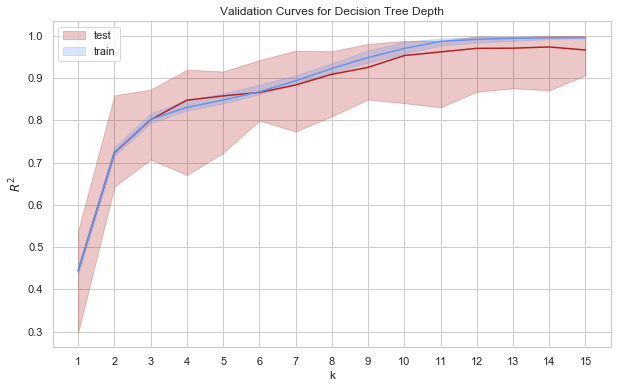

In [19]:
xs = list(range(1, 16))
figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.
axes = figure.add_subplot(1, 1, 1)

test_lower, test_mid, test_upper = zip(*test_curve)
train_lower, train_mid, train_upper = zip(*train_curve)

axes.fill_between(xs, test_lower, test_upper, alpha=0.25, color="firebrick", label="test")
axes.plot(xs, test_mid, color="firebrick")

axes.fill_between(xs, train_lower, train_upper, alpha=0.25, color="cornflowerblue", label="train")
axes.plot(xs, train_mid, color="cornflowerblue")

axes.set_xticks(xs)
axes.set_xticklabels([str(x) for x in xs])

axes.legend()
axes.set_title("Validation Curves for Decision Tree Depth")
axes.set_xlabel("k")
axes.set_ylabel("$R^2$")

plt.show()
plt.close()

We can see steady consistent growth between the training and test data sets until a depth of 9. After 9 they diverge and it is overfitting after. 9 would be the best depth for this model. 

### Cross Validation

With the depth of 9 we will perform 3 rounds of 10 fold cross validation to get a sense of generalization error. 

In [20]:
builder = tree.DecisionTreeRegressor(max_depth = 9)
dtr_results = dtr_cross_validation(formula, builder, insuranceNormal)

In [21]:
print(r"95% CI for R^2:", stats.mstats.mquantiles(dtr_results['test'], [0.025, 0.975]))

95% CI for R^2: [0.81893488 0.98103997]


The 95% credible interval for the R^2 with a depth of 9 at this model is between .868 and .978. This interval looks to be in line with the spread shown for the max depth of 9 in the validation curve plot.

### Learning Curves

In [22]:
from collections import defaultdict

def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [23]:
def dtr_learning_curves(builder, formula, data, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                y = train_data_chunk['log_charges']
                X = train_data_chunk.loc[:, train_data_chunk.columns != 'log_charges']
                model = builder.fit(X, y)
                y_hat = model.predict(X)
                training_r_squared = (stats.pearsonr(y, y_hat)[0])**2
                results["train"][i].append(training_r_squared)
                
                # y, X for test data
                y = test_data['log_charges']
                X = test_data.loc[:, test_data.columns != 'log_charges']
                y_hat = model.predict(X)
                test_r_squared = (stats.pearsonr(y, y_hat)[0])**2
                results["test"][i].append(test_r_squared)
    # process results
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results

In [24]:
result = dtr_learning_curves(tree.DecisionTreeRegressor(max_depth = 9), formula, insuranceNormal)

In [25]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [26]:
def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()

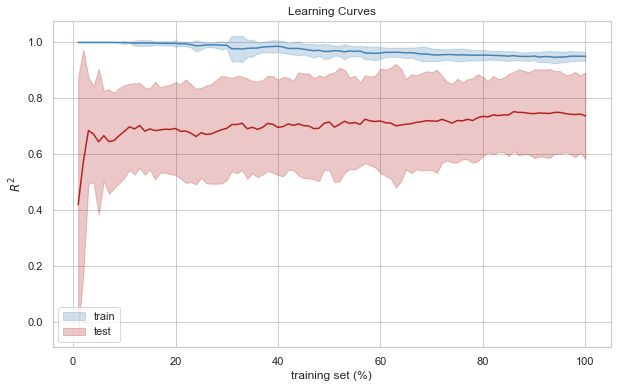

In [27]:
plot_learning_curves(result, "$R^2$")

Here we do see the test set getting closer to the training set as the size percentage progresses to 100%. This can suggest we are overfitting as the test is converging to the training. 

### Model Comparison

We will compare how this model performs compared to that of the original linear regression model.

In [28]:
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

In [29]:
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            #y = test_data['log_charges']
            #X = test_data.loc[:, test_data.columns != 'log_charges']
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

In [30]:
lr_result = cross_validation(models.linear_regression, formula, insuranceNormal, lambda r: (r["sigma"], r["r_squared"]))


In [31]:
dtr_bootstrap = bootstrap_sample(dtr_results['test'], np.mean)
lr_bootstrap = bootstrap_sample([r[1] for r in lr_result], np.mean)
difference = dtr_bootstrap - lr_bootstrap

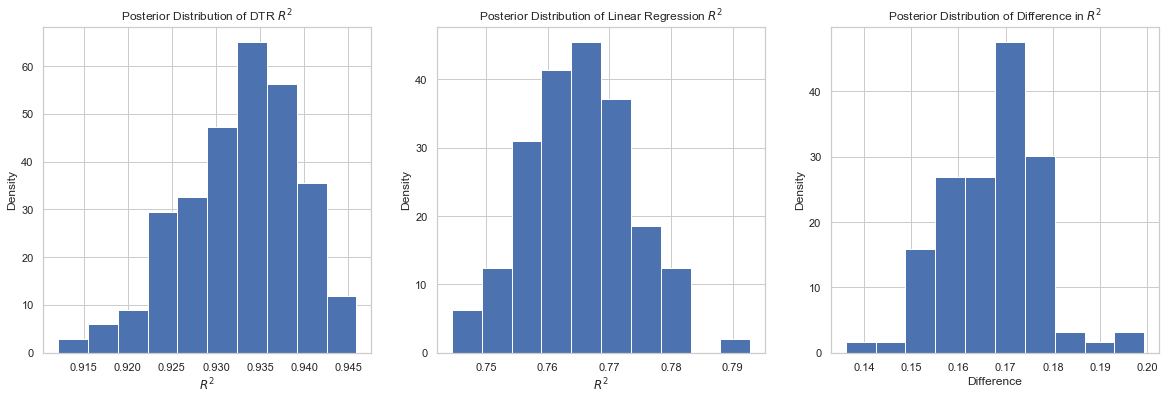

In [32]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(dtr_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of DTR $R^2$")

axes = figure.add_subplot(1, 3, 2)

axes.hist(lr_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Linear Regression $R^2$")

axes = figure.add_subplot(1, 3, 3)

axes.hist( difference, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Difference")
axes.set_title( "Posterior Distribution of Difference in $R^2$")

plt.show()
plt.close()

In [33]:
print("P(DTR > LR)", np.mean(difference > 0))

P(DTR > LR) 1.0


The decision tree R^2 is 100% likely to be greater than the linear regression R^2. The difference is around .14 to .19 larger for the decision tree model.

**Problem 2.**

Now use the [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) on the insurance data set. Use validation curves to optimize the hyperparameters. Estimate generalization error on 3 rounds of 10 fold cross validation. Instead of learning curves, examine the importance of the features. How does this compare with your linear regression from before?

In [34]:
rfr = RandomForestRegressor(max_depth=2, n_estimators=100, random_state=1563498164)

In [35]:
rfr.fit(insuranceNormal.loc[:, insuranceNormal.columns != 'log_charges'],insuranceNormal['log_charges'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1563498164, verbose=0,
           warm_start=False)

In [36]:
rfr.predict(insuranceNormal.loc[:, insuranceNormal.columns != 'log_charges'])

array([ 0.91949756, -1.02955019, -1.02955019, ..., -1.02955019,
       -1.02955019,  0.91949756])

### Validation Curves

In [37]:
def rfr_cross_validation(formula, builder, data, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = {"train": [], "test": []}
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            # y, X for training data
            y = train_data['log_charges']
            X = train_data.loc[:, train_data.columns != 'log_charges']
            model = builder.fit(X, y)
            y_hat = model.predict(X)
            training_r_squared = (stats.pearsonr(y, y_hat)[0])**2
            metrics["train"].append(training_r_squared)
            # y, X for training data
            y = test_data['log_charges']
            X = test_data.loc[:, test_data.columns != 'log_charges']
            y_hat = model.predict(X)
            test_r_squared = (stats.pearsonr(y, y_hat)[0])**2
            metrics["test"].append(test_r_squared)
    return metrics

In [38]:
test_curve = []
train_curve = []
for k in range(1, 16):
    builder = RandomForestRegressor(max_depth=k, n_estimators=100, random_state=1563498164)
    results = rfr_cross_validation(formula, builder, insuranceNormal)
    test_curve.append(stats.mstats.mquantiles(results['test'], [0.025, 0.5, 0.975]))
    train_curve.append(stats.mstats.mquantiles(results['train'], [0.025, 0.5, 0.975]))

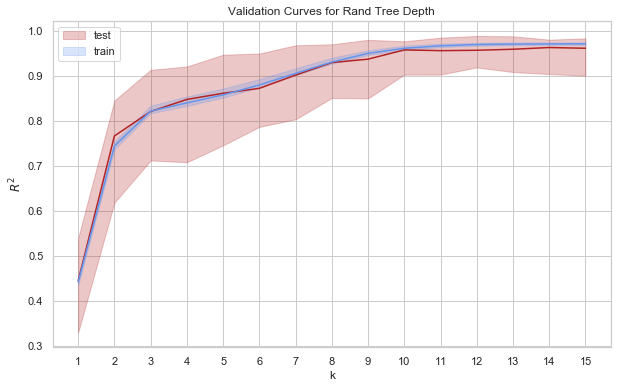

In [39]:
xs = list(range(1, 16))
figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.
axes = figure.add_subplot(1, 1, 1)

test_lower, test_mid, test_upper = zip(*test_curve)
train_lower, train_mid, train_upper = zip(*train_curve)

axes.fill_between(xs, test_lower, test_upper, alpha=0.25, color="firebrick", label="test")
axes.plot(xs, test_mid, color="firebrick")

axes.fill_between(xs, train_lower, train_upper, alpha=0.25, color="cornflowerblue", label="train")
axes.plot(xs, train_mid, color="cornflowerblue")

axes.set_xticks(xs)
axes.set_xticklabels([str(x) for x in xs])

axes.legend()
axes.set_title("Validation Curves for Rand Tree Depth")
axes.set_xlabel("k")
axes.set_ylabel("$R^2$")

plt.show()
plt.close()

The two curves start to diverge slightly around 8 but more so after 10 which is also where they begin to level out. The max depth makes sense to be at about 10. 

### Cross Validation

Now we can use the model built from the validation curves to perform 3 rounds of 10 fold cross validation to get a sense of generalization error.

In [40]:
builder =  RandomForestRegressor(max_depth=10, n_estimators=100, random_state=1563498164)
rfr_results = rfr_cross_validation(formula, builder, insuranceNormal)

In [41]:
print(r"95% CI for R^2:", stats.mstats.mquantiles(rfr_results['test'], [0.025, 0.975]))

95% CI for R^2: [0.89820956 0.980994  ]


With a max dpeth of 10, the Random Forest model has a 95% credible interval between .907 and .981.

### Importance of the Features

In [42]:
print(builder.feature_importances_)

[0.38364942 0.01063322 0.09501517 0.04532716 0.44410792 0.00743833
 0.00811983 0.00570895]


The random forest regressor model used eight features with the first and the fifth being the most influencial by far. 

### Model Comparison

We will compare how this model performs compared to that of the original linear regression model. I will use the linear regression results from prior.

In [43]:
rfr_bootstrap = bootstrap_sample(rfr_results['test'], np.mean)
lr_bootstrap = bootstrap_sample([r[1] for r in lr_result], np.mean)
difference = rfr_bootstrap - lr_bootstrap

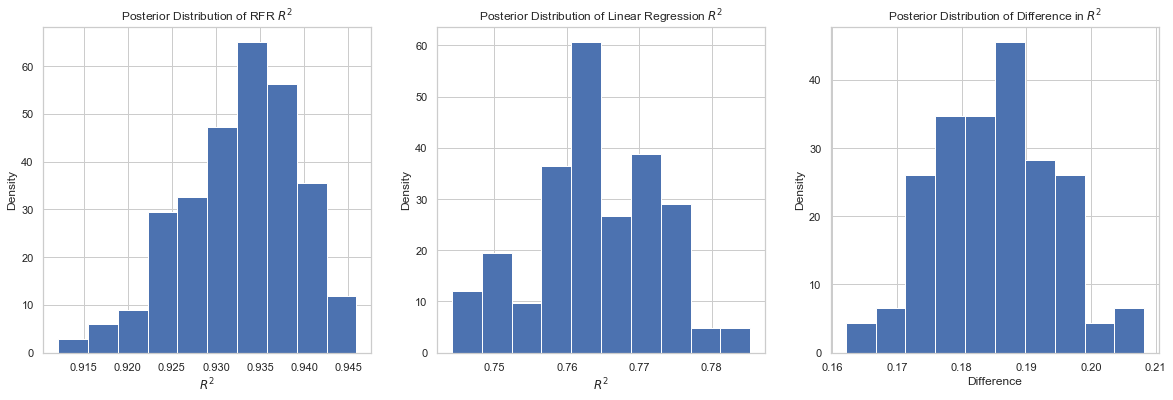

In [44]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(dtr_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of RFR $R^2$")

axes = figure.add_subplot(1, 3, 2)

axes.hist(lr_bootstrap, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Linear Regression $R^2$")

axes = figure.add_subplot(1, 3, 3)

axes.hist( difference, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Difference")
axes.set_title( "Posterior Distribution of Difference in $R^2$")

plt.show()
plt.close()

In [45]:
print("P(DTR > LR)", np.mean(difference > 0))

P(DTR > LR) 1.0


The random forest model R^2 is 100% likely to be greater than the linear regression R^2. The difference is around .15 to .21 larger for the random forest model.